# 2章 画像の局所記述子
- 複数の画像間で点や領域を対応付けする。
- ２種類の局所記述子を使い、パノラマ画像の作成、拡張現実感、３次元復元などを行う。

## 2.1 Harrisコーナー検出器
テキストp.31  
Harrisコーナー検出アルゴリズムを用いて、画像内のコーナーを検出する。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import filters
%matplotlib inline

### harrisコーナー検出機
最も簡単なコーナー記述しの一つ  
画像のコーナーを求める

画像上の点xについて、行列$M_I$を対称行列として次のように定義
$$M_I = \nabla I \nabla I^T  = [\frac{I_x}{I_y}][Ix, Iy]$$

$\nabla I$は画像の勾配

### harrisモジュール


harris.pyで定義される関数

- compute_harris_response(): Harrisコーナー検出器の応答関数を定義する
- get_harris_points(): Harrisコーナー記述子の座標を取得する
- plot_harris_points(): 画像上のHarrisコーナー点を表示する
- get_descriptors(): 画像の特徴量を取得する
- match(): 第1の画像の各コーナー点記述子について、第2の画像の対応点を選択する
- match_twosided(): 双方向でmatch()を用いて一致を調べる
- appendimages(): 2つの画像を左右に並べた画像を返す
- plot_matches(): ２つの画像の対応点を線で結んで画像を表示する

In [2]:
import harris

ModuleNotFoundError: No module named 'harris'

In [4]:
# 画像の読み込み
im = np.array(Image.open('data/empire.jpg').convert('L'))

### compute_harris_response()
Harrisコーナー検出器の応答関数を算出する

```python
def compute_harris_response(im,sigma=3):
    """ グレースケール画像の各ピクセルについて
       Harrisコーナー検出器の応答関数を定義する """

    # 微分係数
    imx = zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (0,1), imx)
    imy = zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (1,0), imy)

    # Harris行列の成分を計算する
    Wxx = filters.gaussian_filter(imx*imx,sigma)
    Wxy = filters.gaussian_filter(imx*imy,sigma)
    Wyy = filters.gaussian_filter(imy*imy,sigma)

    # 判別式と対角成分
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy

    return Wdet / Wtr
```

In [13]:
# Harris検出器による画像の処理
harrisim = harris.compute_harris_response(im)
harrisim.shape

(800, 569)

In [14]:
harrisim

array([[  3.86893208e-04,   4.94406378e-04,   7.02395089e-04, ...,
          1.26135274e-02,   1.25711627e-02,   1.23921030e-02],
       [  3.97860476e-04,   5.11607306e-04,   7.29881538e-04, ...,
          1.25060957e-02,   1.24706931e-02,   1.22956827e-02],
       [  4.17350917e-04,   5.42276074e-04,   7.78624073e-04, ...,
          1.20727290e-02,   1.20770236e-02,   1.19260659e-02],
       ..., 
       [  1.39439568e-04,   1.38533109e-04,   1.36258896e-04, ...,
          1.60779413e-01,   1.56946670e-01,   1.52765869e-01],
       [  1.22086293e-04,   1.21496059e-04,   1.20047441e-04, ...,
          1.56940218e-01,   1.54374675e-01,   1.50906688e-01],
       [  1.14646391e-04,   1.14292079e-04,   1.13407191e-04, ...,
          1.52307607e-01,   1.50639628e-01,   1.47702623e-01]])

### get_harris_points():
Harris応答画像からコーナーを返す。

```python
def get_harris_points(harrisim,min_dist=10,threshold=0.1):
    """ Harris応答画像からコーナーを返す。
     min_distはコーナーや画像境界から分離する最小ピクセル数 """

    # 閾値thresholdを超えるコーナー候補を見つける
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1

    # 候補の座標を得る
    coords = array(harrisim_t.nonzero()).T

    # 候補の値を得る
    candidate_values = [harrisim[c[0],c[1]] for c in coords]

    # 候補をソートする
    index = argsort(candidate_values)

    # 許容する点の座標を配列に格納する
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1

    # 最小距離を考慮しながら、最良の点を得る
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+min_dist),
                    (coords[i,1]-min_dist):(coords[i,1]+min_dist)] = 0

    return filtered_coords
```

In [16]:
# min_dist=6, threshold=0.1でHarrisコーナー点を抽出する
filtered_coords = harris.get_harris_points(harrisim, min_dist=6, threshold=0.1)

In [17]:
# Harrisコーナー点の数
len(filtered_coords)

871

In [18]:
# １０個だけ座標を表示
filtered_coords[:10]

[array([760, 543]),
 array([558, 339]),
 array([707, 153]),
 array([785, 380]),
 array([765, 365]),
 array([491, 474]),
 array([720, 157]),
 array([726, 410]),
 array([707, 408]),
 array([669, 321])]

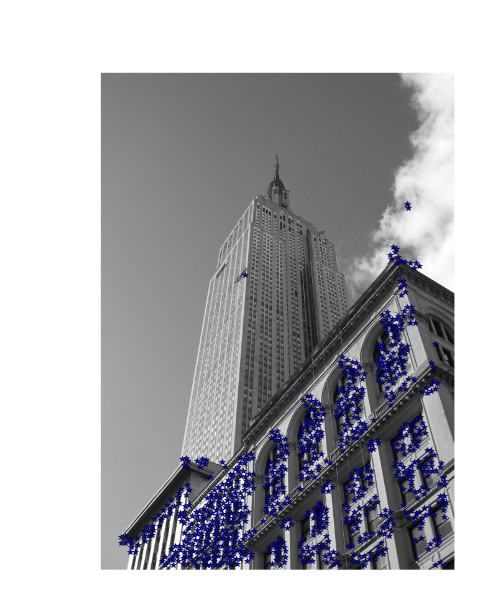

In [19]:
# 画像上にHarrisコーナー点をプロットする
harris.plot_harris_points(im, filtered_coords)

### 2.1.1 画像間の対応点を見つける
異なる画像ファイルの特徴点を比較して、対応する点を見つける

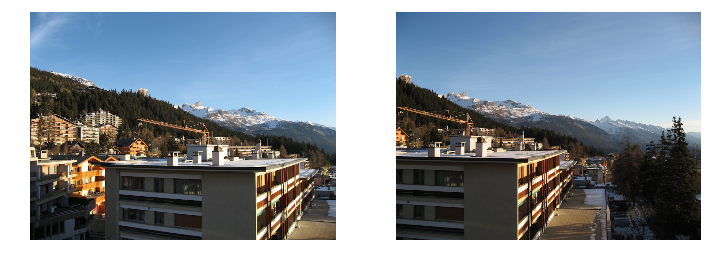

In [32]:
# 住宅のある風景写真の比較
im1 = np.array(Image.open("data/crans_1_small.jpg"))
im2 = np.array(Image.open("data/crans_2_small.jpg"))

# 比較する画像の表示
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(im1)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(im2)
plt.axis('off')
plt.show()

### harrisモジュール内の関数
```python
def get_descriptors(image,filtered_coords,wid=5):
    """ 各点について、点の周辺で幅 2*wid+1 の近傍ピクセル値を返す。
      （点の最小距離 min_distance > wid を仮定する）"""
    desc = []
    for coords in filtered_coords:
        patch = image[coords[0]-wid:coords[0]+wid+1,
                  coords[1]-wid:coords[1]+wid+1].flatten() 
        desc.append(patch)

    return desc


def match(desc1,desc2,threshold=0.5):
    """ 正規化相互相関を用いて、第1の画像の各コーナー点記述子について、
      第2の画像の対応点を選択する。"""
    n = len(desc1[0])

    # 対応点ごとの距離
    d = -ones((len(desc1),len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - mean(desc1[i])) / std(desc1[i])
            d2 = (desc2[j] - mean(desc2[j])) / std(desc2[j])
            ncc_value = sum(d1 * d2) / (n-1)
            if ncc_value > threshold:
                d[i,j] = ncc_value

    ndx = argsort(-d)
    matchscores = ndx[:,0]

    return matchscores


def match_twosided(desc1,desc2,threshold=0.5):
    """ match()の双方向で一致を調べるバージョン """

    matches_12 = match(desc1,desc2,threshold)
    matches_21 = match(desc2,desc1,threshold)

    ndx_12 = where(matches_12 >= 0)[0]

    # 非対称の場合を除去する
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1

    return matches_12


def appendimages(im1,im2):
    """ 2つの画像を左右に並べた画像を返す """

    # 行の少ない方を選び、空行を0で埋める
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]

    if rows1 < rows2:
        im1 = concatenate((im1,zeros((rows2-rows1,im1.shape[1]))),axis=0)
    elif rows1 > rows2:
        im2 = concatenate((im2,zeros((rows1-rows2,im2.shape[1]))),axis=0)
    # 行が同じなら、0で埋める必要はない

    return concatenate((im1,im2), axis=1)


def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    """ 対応点を線で結んで画像を表示する
    入力： im1,im2（配列形式の画像）、locs1,locs2（特徴点座標）
       machescores（match()の出力）、
       show_below（対応の下に画像を表示するならTrue）"""

    im3 = appendimages(im1,im2)
    if show_below:
        im3 = vstack((im3,im3))

    imshow(im3)

    cols1 = im1.shape[1]
    for i,m in enumerate(matchscores):
        if m>0: plot([locs1[i][1],locs2[m][1]+cols1],[locs1[i][0],locs2[m][0]],'c')
    axis('off')
```

### 画像のリサイズ
J. E. Solemのサンプルコードでは上記のimresize関数を使って、  
画像のリサイズを行い、処理を軽くしている。  
ただし以下のオリジナルのコードは、Python 3.xではTypeErrorが出る。  
除算(/)を小数を除いた整数の商を得るよう(//)に変える。

**オリジナル**
```python
im1 = imresize(im1,(im1.shape[1]/2,im1.shape[0]/2))
im2 = imresize(im2,(im2.shape[1]/2,im2.shape[0]/2))
```

**修正**
```python
im1 = imresize(im1,(im1.shape[1]//2,im1.shape[0]//2))
im2 = imresize(im2,(im2.shape[1]//2,im2.shape[0]//2))
```

In [33]:
def imresize(im,sz):
    """    Resize an image array using PIL. """
    pil_im = Image.fromarray(np.uint8(im))
    
    return np.array(pil_im.resize(sz))

In [34]:
# 比較する際は白黒写真にする
im1 = np.array(Image.open("data/crans_1_small.jpg").convert("L"))
im2 = np.array(Image.open("data/crans_2_small.jpg").convert("L"))
print(im1.shape)
print(im2.shape)

(750, 1000)
(750, 1000)


In [35]:
# イメージのリサイズを行う
# Python 3.xでは除算の結果をintにする場合、'//'を使う
im1 = imresize(im1,(im1.shape[1]//2,im1.shape[0]//2))
im2 = imresize(im2,(im2.shape[1]//2,im2.shape[0]//2))
print(im1.shape)
print(im2.shape)

(375, 500)
(375, 500)


starting matching


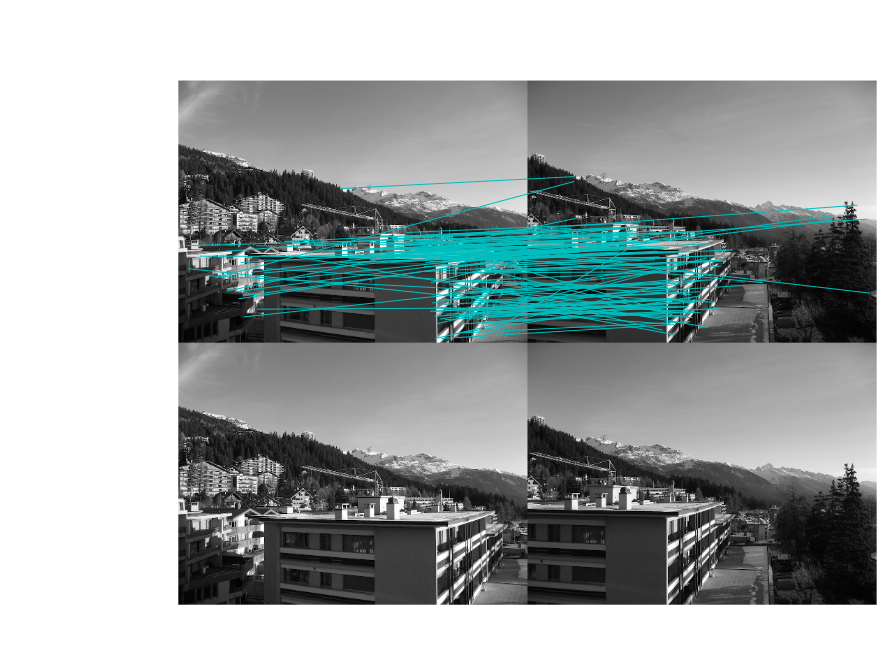

In [36]:
# ２枚の画像のHarrisコーナー点の算出を行い、一致する点を線で結ぶ
wid = 5
harrisim = harris.compute_harris_response(im1,5) 
filtered_coords1 = harris.get_harris_points(harrisim,wid+1) 
d1 = harris.get_descriptors(im1,filtered_coords1,wid)

harrisim = harris.compute_harris_response(im2,5) 
filtered_coords2 = harris.get_harris_points(harrisim,wid+1) 
d2 = harris.get_descriptors(im2,filtered_coords2,wid)

print('starting matching')
matches = harris.match_twosided(d1,d2)

plt.figure(figsize=(15,15))
plt.gray() 
harris.plot_matches(im1,im2,filtered_coords1,filtered_coords2,matches) 
plt.show()

### 1組目の比較の結果
２枚の写真はほぼ平行に移動して撮影した写真である。  
Harrisコーナー点を検出して、２枚の写真で類似した特徴を持つ点を線で結んだ。  
建物の角などの結びつけは比較的うまくいっているが、右の写真にしかない木にも  
一致線が結ばれてしまい、いくつかの点は一致していない。

### 2組目
サンフランシスコと思われる街の風景

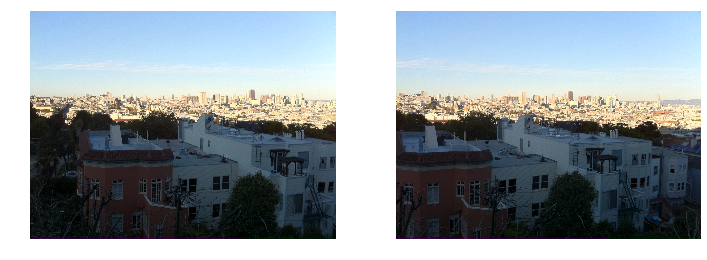

In [37]:
# 比較する画像の読み込み
im1 = np.array(Image.open("data/sf_view1.jpg"))
im2 = np.array(Image.open("data/sf_view2.jpg"))

# 比較する画像の表示
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(im1)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(im2)
plt.axis('off')
plt.show()

starting matching


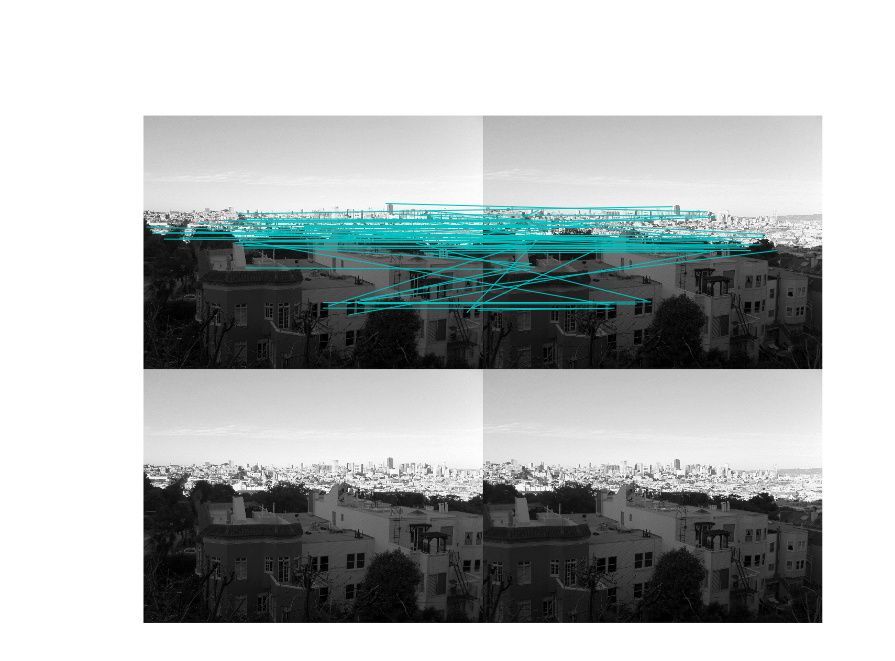

In [38]:
# 比較する画像を白黒で読み込む
im1 = np.array(Image.open("data/sf_view1.jpg").convert("L"))
im2 = np.array(Image.open("data/sf_view2.jpg").convert("L"))

# イメージのリサイズを行う
im1 = imresize(im1,(im1.shape[1]//2,im1.shape[0]//2))
im2 = imresize(im2,(im2.shape[1]//2,im2.shape[0]//2))

# ２枚の画像のHarrisコーナー点の算出を行い、一致する点を線で結ぶ
wid = 5
harrisim = harris.compute_harris_response(im1,5) 
filtered_coords1 = harris.get_harris_points(harrisim,wid+1) 
d1 = harris.get_descriptors(im1,filtered_coords1,wid)

harrisim = harris.compute_harris_response(im2,5) 
filtered_coords2 = harris.get_harris_points(harrisim,wid+1) 
d2 = harris.get_descriptors(im2,filtered_coords2,wid)

print('starting matching')
matches = harris.match_twosided(d1,d2)

plt.figure(figsize=(15,12))
plt.gray() 
harris.plot_matches(im1,im2,filtered_coords1,filtered_coords2,matches) 
plt.show()

### 2組目の結果
2組目もほぼ平行に移動して撮影した写真である。  
ほぼ水平に走る直線は正しく一致しているが、斜めに走る線は誤った結びつけになる。

### 3組目
タヌキの人形の写真

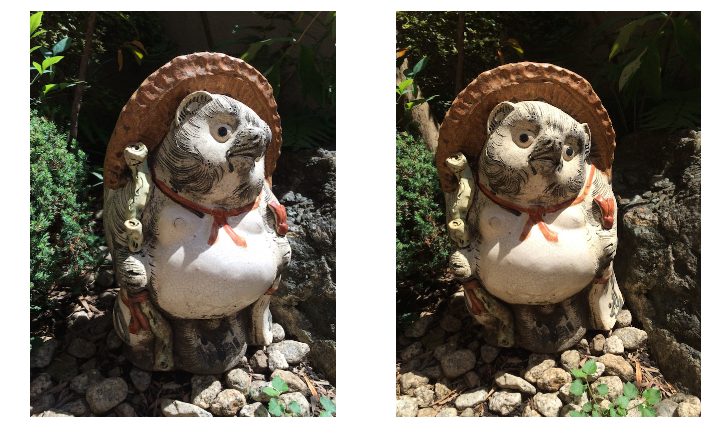

In [39]:
# 比較する画像の読み込み
im1 = np.array(Image.open("data/tanuki_1.jpg"))
im2 = np.array(Image.open("data/tanuki_2.jpg"))

# 比較する画像の表示
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(im1)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(im2)
plt.axis('off')
plt.show()

starting matching


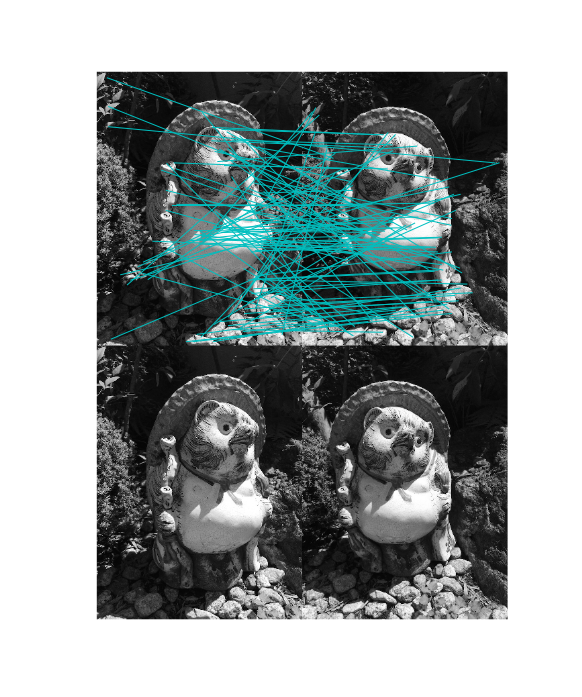

In [40]:
# 画像の読み込み
im1 = np.array(Image.open("data/tanuki_1.jpg").convert("L"))
im2 = np.array(Image.open("data/tanuki_2.jpg").convert("L"))

# イメージのリサイズを行う
im1 = imresize(im1,(im1.shape[1]//2,im1.shape[0]//2))
im2 = imresize(im2,(im2.shape[1]//2,im2.shape[0]//2))

# ２枚の画像のHarrisコーナー点の算出を行い、一致する点を線で結ぶ
wid = 5
harrisim = harris.compute_harris_response(im1,5) 
filtered_coords1 = harris.get_harris_points(harrisim,wid+1) 
d1 = harris.get_descriptors(im1,filtered_coords1,wid)

harrisim = harris.compute_harris_response(im2,5) 
filtered_coords2 = harris.get_harris_points(harrisim,wid+1) 
d2 = harris.get_descriptors(im2,filtered_coords2,wid)

print('starting matching')
matches = harris.match_twosided(d1,d2)

plt.figure(figsize=(15,12))
plt.gray() 
harris.plot_matches(im1,im2,filtered_coords1,filtered_coords2,matches) 
plt.show()

### 結果
これまでの2組の比較に比べると、対応点の線の並び方がバラバラになっている。  
これはタヌキの写真を平行移動で撮影せず、タヌキを中心に向きを変えて撮影した影響があると思われる。